### EDA
Notebook to explore data set, filter for clustering, and visualizations to aid in clustering

In [15]:
import sys
import os
import pandas as pd
sys.path.append(os.path.abspath('..'))
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
import src.processing.data_processor as dp

In [17]:
processor = dp.UFCDataProcessor('../data/raw/')
df = processor.process_data()

INFO:src.processing.data_processor:DataProcessor initialized with data path: ../data/raw/
INFO:src.processing.data_processor:Starting simplified processing pipeline (binary outcomes only)...
INFO:src.processing.data_processor:Data loaded successfully. 8250 events, 2598 fighters, 8250 fights.
INFO:src.processing.data_processor:Found 146 fights (1.77%) with null winner_id - these will be excluded
INFO:src.processing.data_processor:Preparing fight-level data with binary outcomes only...
INFO:src.processing.data_processor:Excluded 146 fights with non-binary outcomes (draws/no contests/etc.)
INFO:src.processing.data_processor:Prepared fighter-level data with 16208 records from binary outcomes
INFO:src.processing.data_processor:Aggregating fighter statistics...
INFO:src.processing.data_processor:Method categories found: ['submission' 'decision' 'ko_tko' 'other']
INFO:src.processing.data_processor:Creating method columns...
INFO:src.processing.data_processor:Aggregated data for 2591 fighters


In [4]:
df.columns

Index(['id', 'total_UFC_fights', 'UFC_wins', 'UFC_losses', 'match_time_sec',
       'total_rounds', 'kd', 'sig_stlanded', 'sig_statmpted', 'total_stlanded',
       'total_statmpted', 'td_landed', 'td_atmpted', 'ctrl', 'head_landed',
       'head_atmpted', 'body_landed', 'body_atmpted', 'leg_landed',
       'leg_atmpted', 'dist_landed', 'dist_atmpted', 'clinch_landed',
       'clinch_atmpted', 'ground_landed', 'ground_atmpted', 'suatt', 'name',
       'division', 'wins_by_ko_tko', 'losses_by_ko_tko', 'wins_by_submission',
       'losses_by_submission', 'wins_by_decision', 'losses_by_decision',
       'wins_by_other', 'losses_by_other', 'career_sig_st_acc',
       'career_total_st_acc', 'career_td_acc', 'career_head_acc',
       'career_body_acc', 'career_leg_acc', 'career_dist_acc',
       'career_clinch_acc', 'career_ground_acc', 'sig_st_landed_per_min',
       'td_landed_per_min', 'kd_per_min', 'avg_fight_time_sec',
       'win_percentage', 'finish_rate', 'ko_tko_win_rate',
       'ko

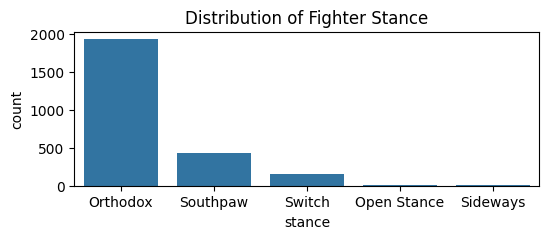

In [21]:
# visualize stance distribution
plt.figure(figsize=(6,2))
sns.countplot(data=df, x='stance', order=df['stance'].value_counts().index)
plt.title('Distribution of Fighter Stance');

In [8]:
# Reclassify southpaw and switch stances as orthodox for simplicity
df['stance'] = df['stance'].replace({'Open Stance':'Orthodox', 'Sideways':'Orthodox'})

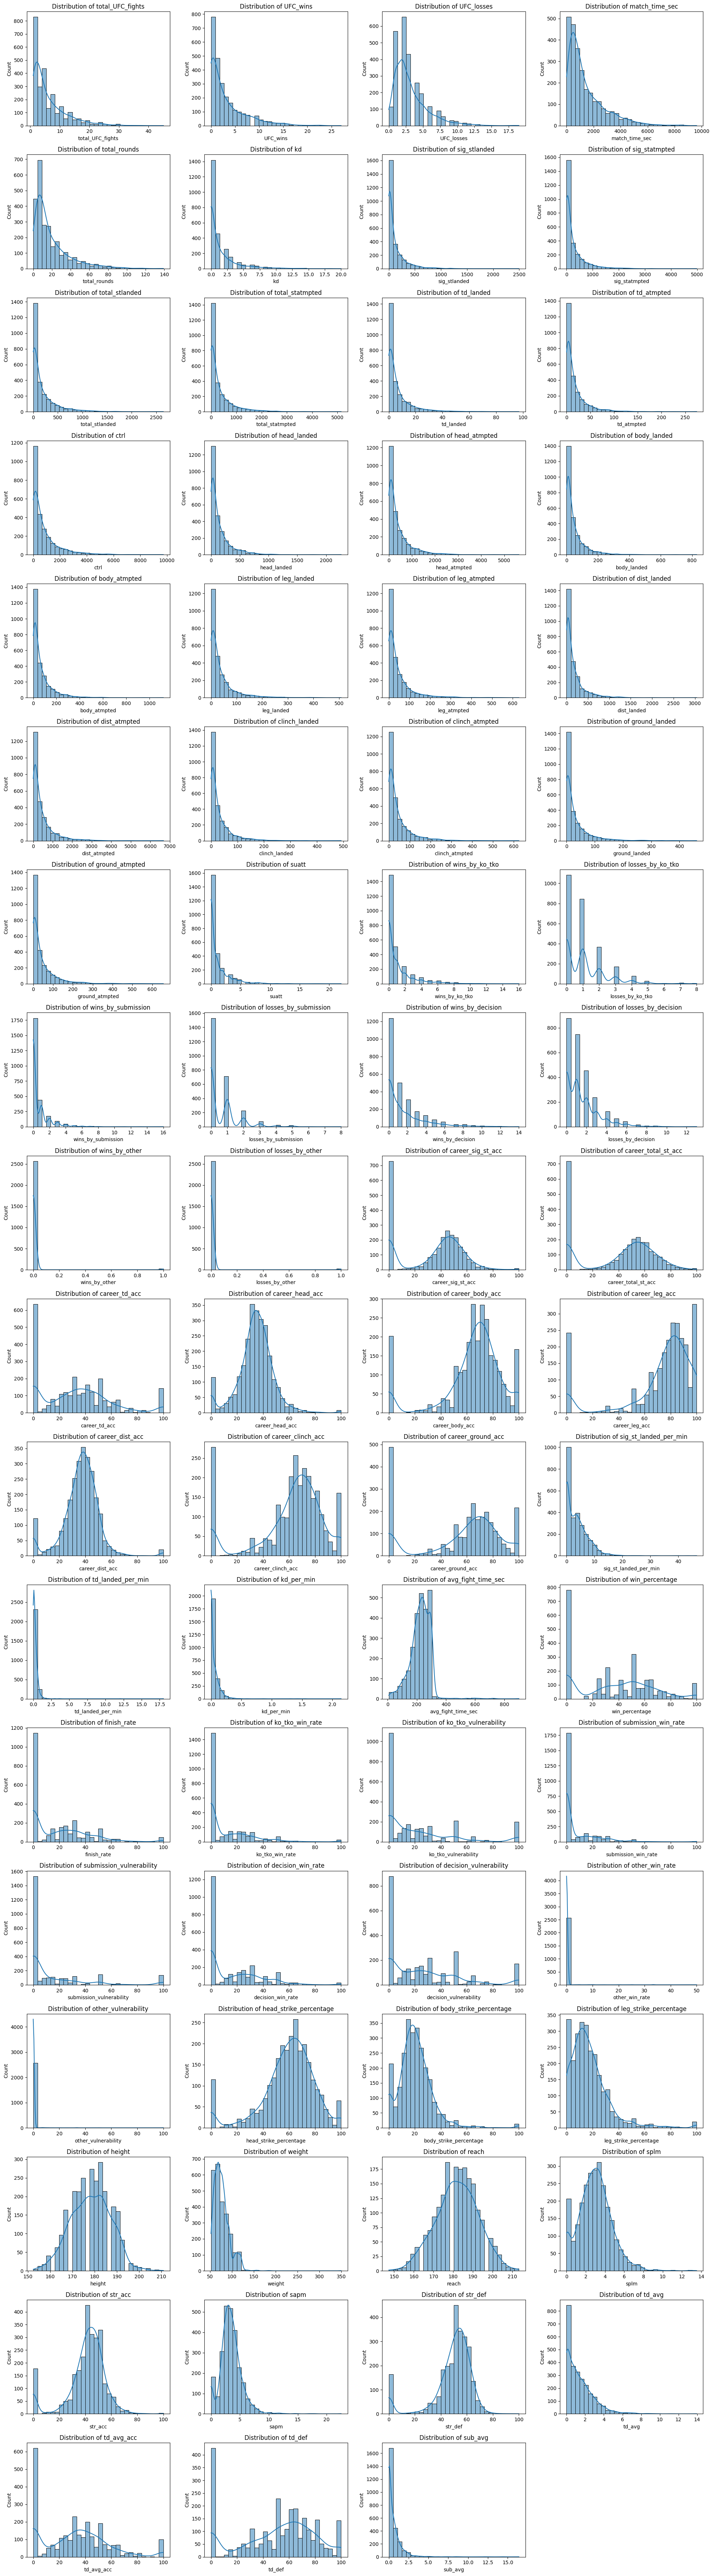

In [9]:
# Select numeric columns for distribution visualization
numeric_cols = df.select_dtypes(include=['number']).columns

# Set up the grid for subplots
num_cols = len(numeric_cols)
num_rows = (num_cols // 4) + (num_cols % 4 > 0)  # Creates a grid with up to 4 plots per row

fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot distributions
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


## Data Quality and Validation

In [22]:
# Check for impossible values in dataset
df[['name','UFC_wins',
     'UFC_losses', 
     'total_UFC_fights',
       'wins_by_other']].loc[df['UFC_losses'] + df['UFC_wins'] != df['total_UFC_fights']]

,name,UFC_wins,UFC_losses,total_UFC_fights,wins_by_other


In [13]:
# Sanity check on a few well known fighters
df[['name', 'UFC_wins','total_UFC_fights',
                         'UFC_losses']].loc[df['name'] == 'Dustin Poirier'].T

,32
name,Dustin Poirier
UFC_wins,22
total_UFC_fights,30
UFC_losses,8


In [23]:
df.columns

Index(['id', 'total_UFC_fights', 'UFC_wins', 'UFC_losses', 'match_time_sec',
       'total_rounds', 'kd', 'sig_stlanded', 'sig_statmpted', 'total_stlanded',
       'total_statmpted', 'td_landed', 'td_atmpted', 'ctrl', 'head_landed',
       'head_atmpted', 'body_landed', 'body_atmpted', 'leg_landed',
       'leg_atmpted', 'dist_landed', 'dist_atmpted', 'clinch_landed',
       'clinch_atmpted', 'ground_landed', 'ground_atmpted', 'suatt', 'name',
       'division', 'wins_by_ko_tko', 'losses_by_ko_tko', 'wins_by_submission',
       'losses_by_submission', 'wins_by_decision', 'losses_by_decision',
       'wins_by_other', 'losses_by_other', 'career_sig_st_acc',
       'career_total_st_acc', 'career_td_acc', 'career_head_acc',
       'career_body_acc', 'career_leg_acc', 'career_dist_acc',
       'career_clinch_acc', 'career_ground_acc', 'sig_st_landed_per_min',
       'td_landed_per_min', 'kd_per_min', 'avg_fight_time_sec',
       'win_percentage', 'finish_rate', 'ko_tko_win_rate',
       'ko

In [29]:
# check for accuracy greater than 100%
acc_cols = [col for col in df.columns if 'acc'in col or 'rate' in col]

for col in acc_cols:
    if (df[col] > 100).any():
        print(f"Column {col} has values greater than 100%") # No columns have values greater than 100%

In [ ]:
# Check if any fighters have no wins and no losses
df.loc[(df['UFC_wins'] == 0) & (df['UFC_losses'] == 0)]# No fighters with no wins and no losses

,id,total_UFC_fights,UFC_wins,UFC_losses,match_time_sec,total_rounds,kd,sig_stlanded,sig_statmpted,total_stlanded,...,stance,dob,splm,str_acc,sapm,str_def,td_avg,td_avg_acc,td_def,sub_avg


In [31]:
# Check for fighters with negative values in any numeric columns
negative_values = df[numeric_cols].lt(0).any(axis=1)
df[negative_values] # No fighters with negative values in any numeric columns

,id,total_UFC_fights,UFC_wins,UFC_losses,match_time_sec,total_rounds,kd,sig_stlanded,sig_statmpted,total_stlanded,...,stance,dob,splm,str_acc,sapm,str_def,td_avg,td_avg_acc,td_def,sub_avg


## Missinge Values Assesment

In [36]:
# df.shape # (2598, 77)

# Check for missing values
df.loc[df.isnull().any(axis=1)].shape # (1246, 77) out of 2598 rows have at least one missing value

(1236, 77)

In [37]:
# count missing values per column
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
missing_counts 

# Most common missing value nick name- not important for clustering

# Age can be dropped- not important for clustering

# Need to filter or impute very important variables - stance, reach, height - most likely to be important for clustering

nick_name    912
reach        649
dob          155
stance        74
height        21
weight        18
dtype: int64

## Fight minimums

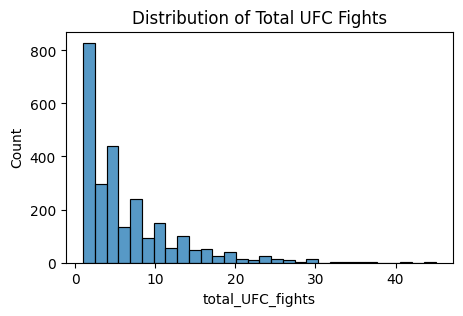

In [42]:
# Fight distribution
plt.figure(figsize=(5,3))
sns.histplot(df['total_UFC_fights'], bins=30, kde=False)
plt.title('Distribution of Total UFC Fights');

In [46]:
df['total_UFC_fights'].describe()

count    2591.000000
mean        6.255500
std         5.922761
min         1.000000
25%         2.000000
50%         4.000000
75%         9.000000
max        45.000000
Name: total_UFC_fights, dtype: float64

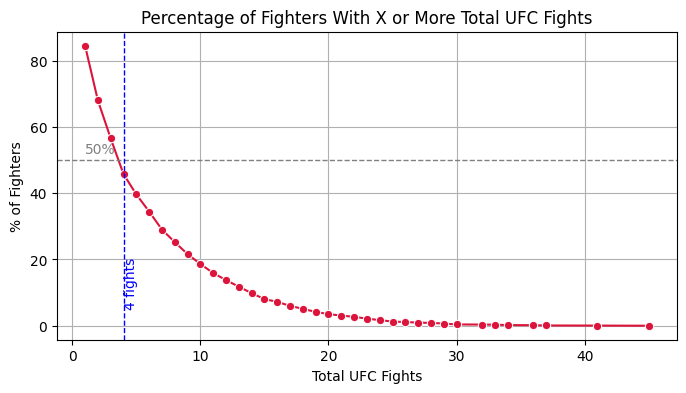

In [58]:
# Calculate the inverse cumulative percentage correctly
fight_counts = df['total_UFC_fights'].value_counts().sort_index()
cumulative_pct = fight_counts.cumsum() / len(df) * 100
inverse_cumulative_pct = 100 - cumulative_pct

plt.figure(figsize=(8,4))
sns.lineplot(x=inverse_cumulative_pct.index, y=inverse_cumulative_pct.values, marker='o', color='crimson')
plt.xlabel('Total UFC Fights')
plt.ylabel('% of Fighters')
plt.title('Percentage of Fighters With X or More Total UFC Fights')
plt.grid(True)

# Add a horizontal line at 50%
plt.axhline(50, color='gray', linestyle='--', linewidth=1)
plt.text(inverse_cumulative_pct.index.min(), 51, '50%', color='gray', va='bottom')

# Add a vertical line where 50% fall under x number of fights
if (inverse_cumulative_pct <= 50).any():
    x_50 = inverse_cumulative_pct[inverse_cumulative_pct <= 50].index[0]
    plt.axvline(x_50, color='blue', linestyle='--', linewidth=1)
    plt.text(x_50, 5, f'{x_50} fights', color='blue', rotation=90, va='bottom')

plt.show()